# OCR: Handwriting recognition with OpenCV, Keras, and TensorFlow

### Install the necessary packages

In [1]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 30kB/s 
     |████████████████████████████████| 460kB 52.5MB/s 
     |████████████████████████████████| 2.9MB 32.3MB/s 
     |████████████████████████████████| 3.0MB 29.0MB/s 
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


In [2]:
%cd ocr-handwriting-recognition

/content/ocr-handwriting-recognition


### Import Packages

In [3]:
# import the necessary packages
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
from matplotlib import pyplot as plt
import numpy as np
import argparse
import imutils
import cv2

In [4]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Implementing our handwriting recognition OCR script with OpenCV, Keras, and TensorFlow

In [5]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"image": "images/hello_world.png",
	"model": "handwriting.model"
}

In [6]:
# load the handwriting OCR model
print("[INFO] loading handwriting OCR model...")
model = load_model(args["model"])

[INFO] loading handwriting OCR model...


In [7]:
# load the input image from disk, convert it to grayscale, and blur
# it to reduce noise
image = cv2.imread(args["image"])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

# initialize the list of contour bounding boxes and associated
# characters that we'll be OCR'ing
chars = []

In [8]:
# loop over the contours
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)

	# filter out bounding boxes, ensuring they are neither too small
	# nor too large
	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
		# extract the character and threshold it to make the character
		# appear as *white* (foreground) on a *black* background, then
		# grab the width and height of the thresholded image
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape

		# if the width is greater than the height, resize along the
		# width dimension
		if tW > tH:
			thresh = imutils.resize(thresh, width=32)
		# otherwise, resize along the height
		else:
			thresh = imutils.resize(thresh, height=32)

        # re-grab the image dimensions (now that its been resized)
		# and then determine how much we need to pad the width and
		# height such that our image will be 32x32
		(tH, tW) = thresh.shape
		dX = int(max(0, 32 - tW) / 2.0)
		dY = int(max(0, 32 - tH) / 2.0)

		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (32, 32))

		# prepare the padded image for classification via our
		# handwriting OCR model
		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)

		# update our list of characters that will be OCR'd
		chars.append((padded, (x, y, w, h)))

In [9]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")

# OCR the characters using our handwriting recognition model
preds = model.predict(chars)

# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

[INFO] H - 92.48%


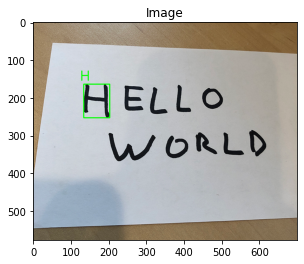

[INFO] W - 54.50%


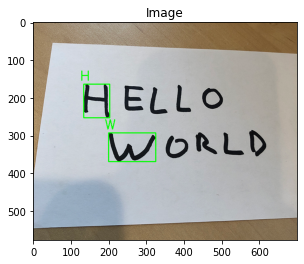

[INFO] E - 94.93%


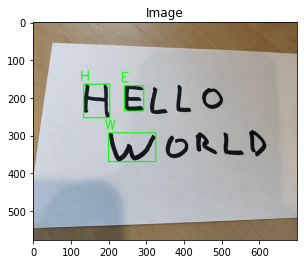

[INFO] L - 97.58%


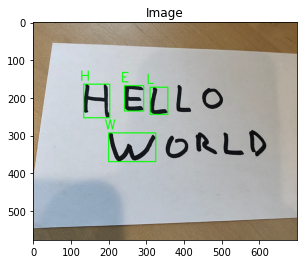

[INFO] 2 - 65.73%


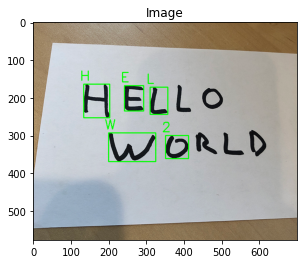

[INFO] L - 96.56%


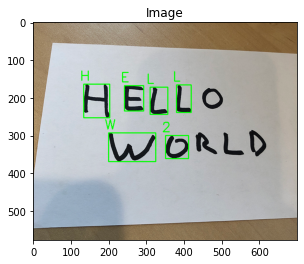

[INFO] R - 97.31%


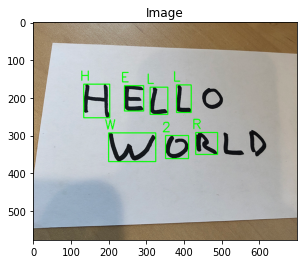

[INFO] 0 - 37.92%


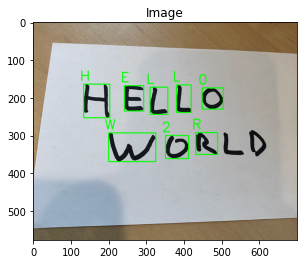

[INFO] L - 97.13%


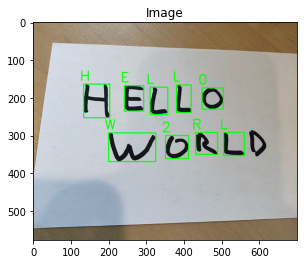

[INFO] D - 97.83%


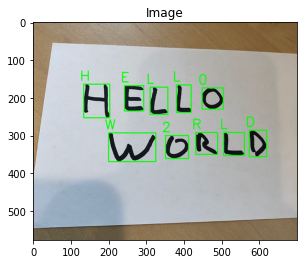

In [10]:
# loop over the predictions and bounding box locations together
for (pred, (x, y, w, h)) in zip(preds, boxes):
	# find the index of the label with the largest corresponding
	# probability, then extract the probability and label
	i = np.argmax(pred)
	prob = pred[i]
	label = labelNames[i]

	# draw the prediction on the image
	print("[INFO] {} - {:.2f}%".format(label, prob * 100))
	cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
	cv2.putText(image, label, (x - 10, y - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

	# show the image
	plt_imshow("Image", image)